# Universidad Autonoma de Aguascalientes
# Departamento: Ciencias de la Computación
# Materia: Machine y Deep Learning
# Profesor: Dr. Francisco Javier Luna Rosas
# Alumnos: 
# Enrique Vélez Durán
# Gabriel Melchor Campos
# Carlos Fernando Nájera Ruiz
# Cristián Israel Donato Flores
#### Semestre: Enero-Junio 2025
## Críticas de Cine
# Análisis de Sentimientos en Reseñas de Películas  

### Este programa implementa un modelo de aprendizaje automático para analizar sentimientos en reseñas de películas. Se aplican técnicas de procesamiento de lenguaje natural (NLP) para limpiar y transformar el texto, incluyendo:  

###    - Tokenización  
###    - Eliminación de stopwords  
###    - Lematización  

### Se entrena un modelo **Skip-Gram** para generar embeddings de palabras, los cuales sirven como entrada para dos modelos de clasificación de sentimientos:  

###    1. **Red Neuronal (NNBP)**  
###    2. **Regresión Logística**  

### Finalmente, se comparan los resultados de ambos modelos mediante métricas de evaluación y matrices de confusión.


## Importación de librerías y configuración inicial

In [11]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Descargar recursos necesarios de NLTK
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Configurar dispositivo (GPU si está disponible, de lo contrario CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cpu


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\velez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\velez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\velez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\velez\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Carga y preprocesamiento del dataset
### Define y aplica una función de preprocesamiento de texto que elimina etiquetas HTML, convierte a minúsculas, elimina caracteres no alfabéticos, tokeniza, elimina stopwords y aplica lematización. Luego aplica esta función a todas las reseñas del dataset.

In [12]:
df = pd.read_csv('movie_data.csv')  # Asegúrate de tener el archivo movie_data.csv
print(f"Número de críticas cargadas: {len(df)}")  # Verifica que se carguen 50,000 críticas

# Lista de palabras a conservar (para capturar negaciones)
custom_stopwords = set(stopwords.words('english')) - {'not', 'no', 'nor'}

# Preprocesamiento de texto con stemming
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Eliminar etiquetas HTML
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Solo letras y espacios
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in custom_stopwords]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

# Aplicar preprocesamiento a todas las críticas
df['tokens'] = df['review'].apply(preprocess_text)
df['processed_review'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

Número de críticas cargadas: 50000


## Creación del vocabulario
### Crea un vocabulario a partir de los tokens procesados, incluyendo solo palabras que aparecen al menos 5 veces. Define también la dimensión de los embeddings (100) que se utilizarán para representar las palabras.

In [13]:
# Crear vocabulario con un mínimo de apariciones
def create_vocabulary(token_lists, min_count=5):
    word_counts = Counter()
    for tokens in token_lists:
        word_counts.update(tokens)
    return {word: idx for idx, (word, count) in enumerate(word_counts.most_common()) if count >= min_count}

vocabulary = create_vocabulary(df['tokens'], min_count=5)
vocab_size = len(vocabulary)
embedding_dim = 100  # Dimensión de los embeddings
print(f"Tamaño del vocabulario: {vocab_size}")

Tamaño del vocabulario: 30153


## Implementación del modelo Skip-Gram
### Define una clase personalizada de Dataset para el modelo Skip-Gram, que genera pares de palabras centrales y contextuales para el entrenamiento del modelo de word embeddings. Incluye muestreo negativo para mejorar la eficiencia del entrenamiento.

In [14]:
class SkipGramSampledDataset(Dataset):
    def __init__(self, token_lists, vocabulary, window_size=2, negative_samples=5, pairs_per_review=20, max_tokens=500):
        self.token_lists = token_lists
        self.vocabulary = vocabulary
        self.window_size = window_size
        self.negative_samples = negative_samples
        self.pairs_per_review = pairs_per_review
        self.vocab_size = len(vocabulary)
        self.max_tokens = max_tokens
        self.fixed_pairs = self.pairs_per_review * (1 + self.negative_samples)

    def __len__(self):
        return len(self.token_lists)

    def __getitem__(self, idx):
        tokens = self.token_lists[idx]
        if self.max_tokens is not None:
            tokens = tokens[:self.max_tokens]
        token_ids = [self.vocabulary[token] for token in tokens if token in self.vocabulary]
        n = len(token_ids)
        centers = []
        contexts = []
        labels = []
        for _ in range(self.pairs_per_review):
            if n == 0:
                centers.extend([0] * (1 + self.negative_samples))
                contexts.extend([0] * (1 + self.negative_samples))
                labels.extend([0] * (1 + self.negative_samples))
            else:
                i = np.random.randint(0, n)
                center = token_ids[i]
                start = max(0, i - self.window_size)
                end = min(n, i + self.window_size + 1)
                context_indices = [j for j in range(start, end) if j != i]
                if context_indices:
                    j = np.random.choice(context_indices)
                    context = token_ids[j]
                    centers.append(center)
                    contexts.append(context)
                    labels.append(1)
                else:
                    centers.append(center)
                    contexts.append(center)
                    labels.append(0)
                for _ in range(self.negative_samples):
                    negative = np.random.randint(0, self.vocab_size)
                    centers.append(center)
                    contexts.append(negative)
                    labels.append(0)
        return (torch.tensor(centers, dtype=torch.long),
                torch.tensor(contexts, dtype=torch.long),
                torch.tensor(labels, dtype=torch.float))

## Definición y entrenamiento del modelo Skip-Gram
### Define la arquitectura del modelo Skip-Gram utilizando PyTorch. El modelo tiene dos capas de embedding: una para palabras centrales y otra para palabras contextuales. El forward pass calcula la similitud entre los embeddings de palabras centrales y contextuales.

In [ ]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.in_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_embeddings = nn.Embedding(vocab_size, embedding_dim)
    
    def forward(self, center_words, context_words):
        center_embeds = self.in_embeddings(center_words)   # (batch, num_pairs, embedding_dim)
        context_embeds = self.out_embeddings(context_words)  # (batch, num_pairs, embedding_dim)
        scores = torch.sum(center_embeds * context_embeds, dim=2)  # (batch, num_pairs)
        return scores

# Función para obtener embedding ponderado por TF-IDF
def get_weighted_embedding(tokens, vocabulary, embeddings, tfidf_weights):
    token_ids = [vocabulary[token] for token in tokens if token in vocabulary]
    if not token_ids:
        return np.zeros(embedding_dim)
    tfidf_dense = tfidf_weights.toarray()[0]  # Convertir la fila a un array denso
    weights = [tfidf_dense[vocabulary[token]] for token in tokens if token in vocabulary]
    return np.average(embeddings[token_ids], axis=0, weights=weights)

## Definición de la clase ReviewDataset: Conjunto de Datos Personalizado para Críticas
### Define la clase ReviewDataset, que hereda de la clase Dataset de PyTorch. Esta clase personalizada se utiliza para almacenar y manejar datos de críticas, incluyendo características (X) y etiquetas (y). La clase implementa los métodos __len__ para devolver la longitud del dataset y __getitem__ para recuperar un elemento específico del dataset, útil para cargar los datos durante el entrenamiento y la evaluación de modelos de machine learning.

In [17]:
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Definición de la clase NNBPClassifier: Clasificador de Red Neuronal para Tareas de Clasificación Binaria
### Define una clase NNBPClassifier que implementa un clasificador de red neuronal con propagación hacia adelante, utilizando PyTorch. Esta red tiene dos capas ocultas con funciones de activación ReLU y una capa de salida con función de activación Sigmoid para producir un output entre 0 y 1, lo cual es útil para tareas de clasificación binaria.

In [18]:
class NNBPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(NNBPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

## Comparación de Modelos: Red Neuronal vs. Regresión Logística en Clasificación de Sentimientos
### Realiza una comparación entre un modelo de red neuronal y un modelo de regresión logística para la clasificación de sentimientos en críticas de textos. Comienza entrenando un modelo Skip-Gram para generar embeddings de palabras, que luego se ponderan utilizando TF-IDF. Se crean datasets de entrenamiento y prueba, y se instancian los clasificadores de red neuronal y regresión logística. Ambos modelos se entrenan y evalúan, comparando sus métricas de rendimiento, visualizando los resultados a través de gráficos y matrices de confusión, y calculando métricas detalladas como precisión, sensibilidad, especificidad y más. El objetivo es determinar cuál de los dos enfoques es más efectivo para la tarea de clasificación de sentimientos.

Epoch 1, Batch 0, Loss: 4.0600
Epoch 1, Batch 100, Loss: 3.9869
Epoch 1, Batch 200, Loss: 3.8345
Epoch 1, Batch 300, Loss: 3.7861
SkipGram Epoch 1/5, Average Loss: 3.8413
Epoch 2, Batch 0, Loss: 3.7192
Epoch 2, Batch 100, Loss: 3.5831
Epoch 2, Batch 200, Loss: 3.4416
Epoch 2, Batch 300, Loss: 3.3060
SkipGram Epoch 2/5, Average Loss: 3.4744
Epoch 3, Batch 0, Loss: 3.3652
Epoch 3, Batch 100, Loss: 3.1747
Epoch 3, Batch 200, Loss: 3.1245
Epoch 3, Batch 300, Loss: 3.0027
SkipGram Epoch 3/5, Average Loss: 3.1333
Epoch 4, Batch 0, Loss: 2.9744
Epoch 4, Batch 100, Loss: 2.8724
Epoch 4, Batch 200, Loss: 2.7420
Epoch 4, Batch 300, Loss: 2.7166
SkipGram Epoch 4/5, Average Loss: 2.8202
Epoch 5, Batch 0, Loss: 2.7431
Epoch 5, Batch 100, Loss: 2.5777
Epoch 5, Batch 200, Loss: 2.4786
Epoch 5, Batch 300, Loss: 2.4160
SkipGram Epoch 5/5, Average Loss: 2.5112
Classifier Epoch 1/30, Average Loss: 0.6705
Classifier Epoch 2/30, Average Loss: 0.6515
Classifier Epoch 3/30, Average Loss: 0.6362
Classifier Ep

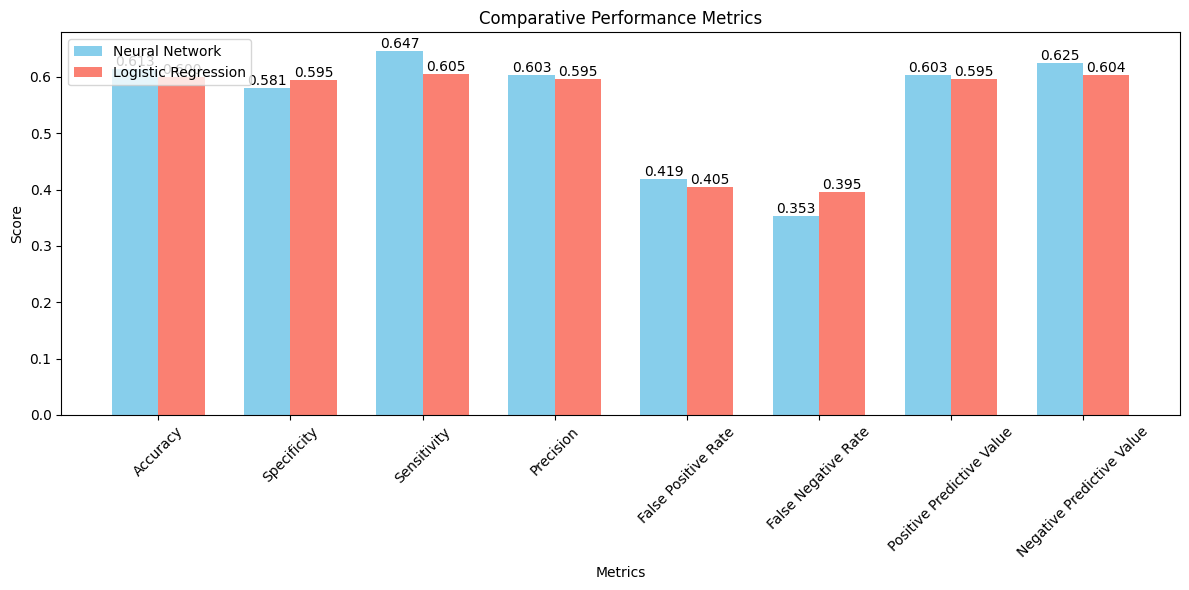

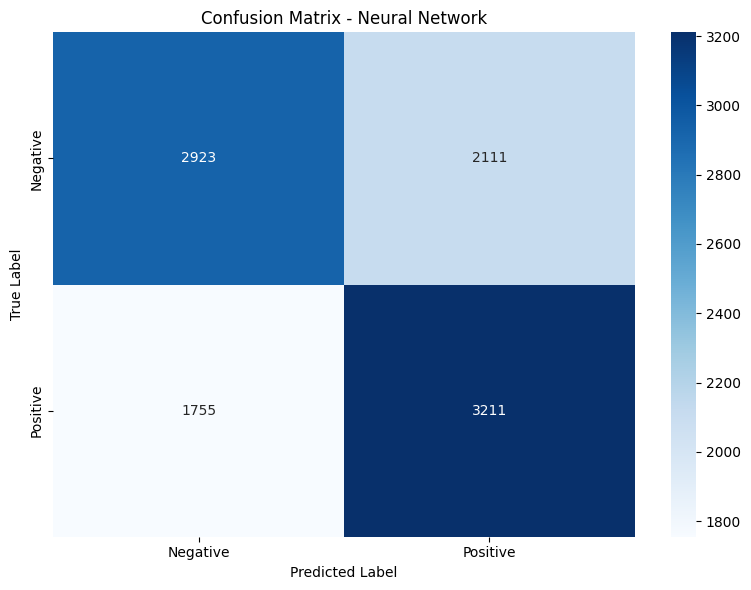

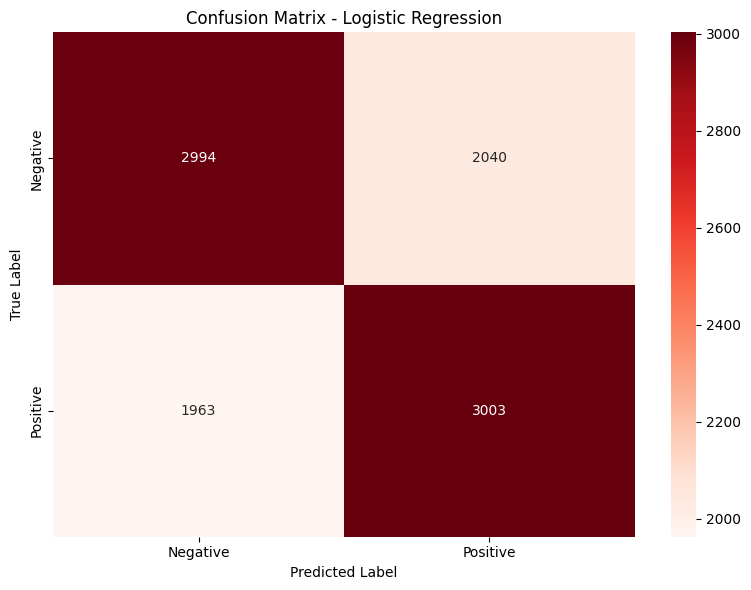


Métricas detalladas del modelo de red neuronal:
Accuracy: 0.613
Specificity: 0.581
Sensitivity: 0.647
Precision: 0.603
False Positive Rate: 0.419
False Negative Rate: 0.353
Positive Predictive Value: 0.603
Negative Predictive Value: 0.625

Métricas detalladas del modelo de regresión logística:
Accuracy: 0.600
Specificity: 0.595
Sensitivity: 0.605
Precision: 0.595
False Positive Rate: 0.405
False Negative Rate: 0.395
Positive Predictive Value: 0.595
Negative Predictive Value: 0.604


In [19]:
if __name__ == '__main__':
    # Crear dataset y DataLoader para Skip-Gram
    sampled_dataset = SkipGramSampledDataset(df['tokens'], vocabulary, window_size=2, negative_samples=5, pairs_per_review=20, max_tokens=500)
    batch_size_sg = 128  # Tamaño del batch optimizado para más datos
    skipgram_loader = DataLoader(sampled_dataset, batch_size=batch_size_sg, shuffle=True, num_workers=0)  # num_workers=0 para Windows

    # Instanciar el modelo, función de pérdida y optimizador para Skip-Gram
    skipgram_model = SkipGramModel(vocab_size, embedding_dim).to(device)
    skipgram_criterion = nn.BCEWithLogitsLoss()
    skipgram_optimizer = optim.Adam(skipgram_model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(skipgram_optimizer, step_size=5, gamma=0.1)

    # Entrenamiento del modelo Skip-Gram
    skipgram_epochs = 5  # Ajustado para el tamaño completo
    for epoch in range(skipgram_epochs):
        total_loss = 0
        for batch_idx, (center, context, label) in enumerate(skipgram_loader):
            if center.nelement() == 0:
                continue
            center = center.to(device)
            context = context.to(device)
            label = label.to(device)
            skipgram_optimizer.zero_grad()
            outputs = skipgram_model(center, context)
            loss = skipgram_criterion(outputs, label)
            loss.backward()
            skipgram_optimizer.step()
            total_loss += loss.item()
            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")
        scheduler.step()
        avg_loss = total_loss / len(skipgram_loader)
        print(f"SkipGram Epoch {epoch+1}/{skipgram_epochs}, Average Loss: {avg_loss:.4f}")
    
    embeddings = skipgram_model.in_embeddings.weight.data.cpu().numpy()

    # Calcular TF-IDF para ponderar embeddings
    vectorizer = TfidfVectorizer(vocabulary=vocabulary)
    tfidf_matrix = vectorizer.fit_transform(df['processed_review'])

    # Obtener embeddings ponderados para cada crítica
    df['review_embedding'] = df.apply(lambda row: get_weighted_embedding(row['tokens'], vocabulary, embeddings, tfidf_matrix[row.name]), axis=1)

    # Preparación de datos para clasificación
    X = np.vstack(df['review_embedding'].values)
    y = df['sentiment'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

    batch_size_cls = 64
    train_dataset = ReviewDataset(X_train_tensor, y_train_tensor)
    test_dataset = ReviewDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size_cls, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_cls, shuffle=False)

    # Instanciar el clasificador
    hidden_dim1 = 128
    hidden_dim2 = 64
    classifier = NNBPClassifier(embedding_dim, hidden_dim1, hidden_dim2).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)

    # Entrenamiento del clasificador con early stopping
    classifier_epochs = 30
    patience = 5
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(classifier_epochs):
        classifier.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = classifier(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Classifier Epoch {epoch+1}/{classifier_epochs}, Average Loss: {avg_loss:.4f}')
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    # Evaluación del clasificador
    classifier.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = classifier(batch_X)
            preds = (outputs >= 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_true.append(batch_y.cpu().numpy())
    y_pred_nn = np.vstack(all_preds)
    y_true = np.vstack(all_true)
    accuracy_nn = accuracy_score(y_true, y_pred_nn)
    print(f'Neural Network Accuracy: {accuracy_nn:.4f}')
    print(classification_report(y_true, y_pred_nn))
    cm_nn = confusion_matrix(y_true, y_pred_nn)
    tn_nn, fp_nn, fn_nn, tp_nn = cm_nn.ravel()
    metrics_nn = {
        'Accuracy': accuracy_nn,
        'Specificity': tn_nn / (tn_nn + fp_nn) if (tn_nn + fp_nn) > 0 else 0,
        'Sensitivity': tp_nn / (tp_nn + fn_nn) if (tp_nn + fn_nn) > 0 else 0,
        'Precision': precision_score(y_true, y_pred_nn),
        'False Positive Rate': fp_nn / (fp_nn + tn_nn) if (fp_nn + tn_nn) > 0 else 0,
        'False Negative Rate': fn_nn / (fn_nn + tp_nn) if (fn_nn + tp_nn) > 0 else 0,
        'Positive Predictive Value': tp_nn / (tp_nn + fp_nn) if (tp_nn + fp_nn) > 0 else 0,
        'Negative Predictive Value': tn_nn / (tn_nn + fn_nn) if (tn_nn + fn_nn) > 0 else 0
    }

    # Entrenamiento y evaluación de Regresión Logística
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    print(f'Logistic Regression Accuracy: {accuracy_lr:.4f}')
    print(classification_report(y_test, y_pred_lr))
    cm_lr = confusion_matrix(y_test, y_pred_lr)
    tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
    metrics_lr = {
        'Accuracy': accuracy_lr,
        'Specificity': tn_lr / (tn_lr + fp_lr) if (tn_lr + fp_lr) > 0 else 0,
        'Sensitivity': tp_lr / (tp_lr + fn_lr) if (tp_lr + fn_lr) > 0 else 0,
        'Precision': precision_score(y_test, y_pred_lr),
        'False Positive Rate': fp_lr / (fp_lr + tn_lr) if (fp_lr + tn_lr) > 0 else 0,
        'False Negative Rate': fn_lr / (fn_lr + tp_lr) if (fn_lr + tp_lr) > 0 else 0,
        'Positive Predictive Value': tp_lr / (tp_lr + fp_lr) if (tp_lr + fp_lr) > 0 else 0,
        'Negative Predictive Value': tn_lr / (tn_lr + fn_lr) if (tn_lr + fn_lr) > 0 else 0
    }

    # Visualización de métricas
    metrics_names = list(metrics_nn.keys())
    nn_values = list(metrics_nn.values())
    lr_values = [metrics_lr[m] for m in metrics_names]

    x = np.arange(len(metrics_names))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, nn_values, width, label='Neural Network', color='skyblue')
    plt.bar(x + width/2, lr_values, width, label='Logistic Regression', color='salmon')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Comparative Performance Metrics')
    plt.xticks(x, metrics_names, rotation=45)
    plt.legend()
    for i, v in enumerate(nn_values):
        plt.text(i - width/2, v, f'{v:.3f}', ha='center', va='bottom')
    for i, v in enumerate(lr_values):
        plt.text(i + width/2, v, f'{v:.3f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

    # Matriz de confusión para Red Neuronal
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix - Neural Network')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Matriz de confusión para Regresión Logística
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Reds',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix - Logistic Regression')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Imprimir métricas detalladas
    print("\nMétricas detalladas del modelo de red neuronal:")
    for metric, value in metrics_nn.items():
        print(f"{metric}: {value:.3f}")

    print("\nMétricas detalladas del modelo de regresión logística:")
    for metric, value in metrics_lr.items():
        print(f"{metric}: {value:.3f}")